# Astrometry with IAC80/Camelot2 data

Camelot2 is the new camera on IAC80 telescope, the field of view increased from 10 to ~15 arcminutes, but the filter wheel (at this moment) still being the same as the previous camera. For this reason there is a vignetting area in the edges of the CCD, regions close to these edges suffer of optical aberrations, therefore, we will proceed to first trim the images. 

## Trimming images with astropy

We start importing the packages basic packages we are going to use. 

The central square region with no vigneting is about 800 from the borders of the image. 

In [1]:
from astropy.io import fits
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats

files = glob('red*.fits')
trim = 800 # we are going to trim the borders so there is no vignetting from the filter wheel
# this way we can use astrometry.net to calibrate our frame  



We select the first image to make sure the pipeline works so we can apply it automatically to all the files in the folder.

In [2]:
infits = files[0]
hdul = fits.open(infits)

First, we will estimate the statistics of the image, like the background and background noise using sigma-clipped statistics. This will remove all the outliers (i.e. the stars) and return the statistics of the bkg in the image

In [3]:
raw_data = hdul[0].data

meanr, medianr, stdr = sigma_clipped_stats(raw_data, sigma=3.0)
print(meanr,medianr,stdr)

658.35004 642.36334 83.61894


Note: median and mean are similar, so that's a good sign 

Noe we plot the reduced image, for this we use a sqrt normalization in order to enhance the bkg and dim stars. 

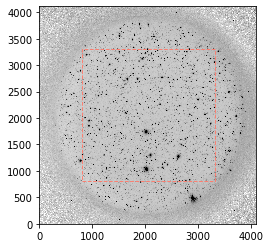

In [4]:
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize

norm = simple_norm(raw_data, 'sqrt', percent=99.)

plt.imshow(raw_data, cmap='Greys', origin='lower', norm=norm)

#here we plot the rectangular aperture we will use to 
#trim the image below
from photutils import RectangularAperture
shape= np.shape(raw_data)
pix_center = np.array(shape)/2 #this is the coordinate of the central pixel
width = shape[0] - 2*trim
height = shape[1] - 2*trim
region = RectangularAperture(pix_center,width,height)

region.plot(color='salmon', ls='dashed')

Note: you can perform different angles and shapes to the aperture you want to use, however this is beyond the scope of this notebook.

We are now ready to trim the image.

In [5]:
hdu = hdul[0].copy() #we copy the image
hdu.data = np.array(hdul[0].data[trim:shape[0]-trim,trim:shape[1]-trim]).T

# updating the headers of the new image
hdu.header['NAXIS2'], hdu.header['NAXIS1'] = np.shape(hdu.data)

We transposed the data matrix in order to have North up East left to make easier when compare with catalogues.

631.9855 623.52893 40.050743


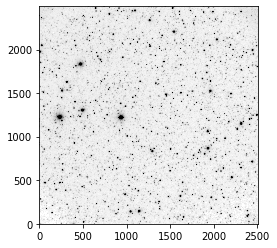

In [6]:
data = hdu.data

mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(mean,median,std)

norm = simple_norm(data, 'sqrt', percent=99.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm,interpolation='nearest')

Note that the statistics of the image improved significantly since we rid of the non illuminated areas of the detector, these values now computed are actually the bkg and bkg noise in the data. 

In [7]:
#here we save the trimmed image 
hdu.writeto('Trim_test.fits',overwrite=True)

## Finding stars and astrometric solution

To obtain the astrometric solution we are going to use astrometry.net API. 

There are two ways you can obtain the astrometric solution of your image, (i) uploading the full fits image and the astrometry.net service will extract the sources from the image and try to find an astrometric solution. (ii) we can upload a list of sources with the physical coordinates along with some extra information.

Given that uploading an image requires transferring roughly $10^4$ times the data as uploading a source list, and we would like to have the astrometry solution for every image we opt for the option (ii)

### Automated star finder with DAOFIND

We will subtract the background and use an instance of DAOStarFinder to find the stars in the image that have FWHMs of around 1 arsecond and have peaks approximately 5-sigma above the background.

First, we determine the number of pixels in 1 arsecond from the header of the image

In [8]:
pixscl = hdu.header['PIXSIZE'] #in arcsec/pixel
fwhm = round(1/pixscl) #we expect seeing of ~1arcsec 

Now we run DAOStarFinder to obtain an astropy Table with the results of the star finder including **instrumental** flux and magnitudes.

DAOStarFinder detect stars in an image using the DAOFIND (Stetson 1987) algorithm.

DAOFIND (Stetson 1987; PASP 99, 191) searches images for local density maxima that have a peak amplitude greater than threshold (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel. The Gaussian kernel is defined by the fwhm, ratio, theta, and sigma_radius input parameters.

In [9]:
from photutils import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median) 

for col in sources.colnames:  # for consistent table output 
     sources[col].info.format = '%.8g'  
print(sources)
print(sources.keys())

 id  xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
---- --------- --------- ---------- ... --- --------- --------- ------------
   1 18.575564 2.6747821 0.31976399 ...   0 558.11304 1.2294959  -0.22431771
   2 634.47035 1.8162532 0.32399791 ...   0  1182.806 2.5449524   -1.0141992
   3  2404.296 1.8401743 0.20205604 ...   0 600.85962 1.4938825   -0.4357911
   4 1714.5276 6.7281396 0.39334601 ...   0 1979.3265 2.1637375  -0.83801145
   5 1078.2086 7.4191137 0.37232389 ...   0  948.6394 1.0700807 -0.073541281
   6 255.36768 8.2801257 0.53779567 ...   0 2929.8457 3.2452517    -1.278121
   7 1928.8968 14.905833  0.4479991 ...   0 2314.8442 2.2233654  -0.86752712
   8 1801.4352 19.629431 0.37869445 ...   0 269.08588 2.2473471  -0.87917537
   9 1271.6155 20.620134 0.40079617 ...   0 1101.4634 1.2179751  -0.21409603
  10 2150.9653 20.319277 0.46871227 ...   0 1045.3428 1.3051746  -0.28917154
 ...       ...       ...        ... ... ...       ...       ...          ...

### Finding the astrometric solution

The most efficient way to use astrometry.net is to pass it a list of sources in an image instead of uploading the entire image. The data can be in an astropy.table.Table, pandas data frame or something other structure.

The only important requirement is that **the list must be sorted by the flux in descending order.**

In [10]:
sources.sort('flux') # Sort sources in ascending order
sources.reverse() # Reverse to get descending order

print(sources[:100])

 id  xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
---- --------- --------- ---------- ... --- --------- --------- ----------
 481 1943.7079 866.05194  0.4019314 ...   0 59542.559  223.5322 -5.8733502
 684 913.68501 1220.6519 0.22804075 ...   0 59504.684 184.51822 -5.6650981
 766 486.91711 1303.9663 0.26317047 ...   0 58877.109 182.45056  -5.652863
1060 456.05875 1831.0332 0.25430458 ...   0 58395.059 172.31338 -5.5907975
 618 2312.3807 1150.0423 0.30941313 ...   0 59196.637 170.53459 -5.5795312
 619 2325.5495 1149.8458 0.54937501 ...   0  58196.52 162.38279   -5.52635
 765 507.89278 1302.8238 0.26440129 ...   0 58791.969 155.56101 -5.4797519
 708 270.53128 1226.8189 0.63023193 ...   0 60207.922 150.01877  -5.440364
 704 274.51469 1225.7665 0.64014127 ...   0 60146.562 148.72947 -5.4309926
 712 258.32393  1227.842  0.6255388 ...   0 60125.129 146.33696 -5.4133851
 ...       ...       ...        ... ... ...       ...       ...        ...
 291 2211.3779 533.39569 

In [11]:
np.max(sources['ycentroid'])

2494.088231022615

Given that this is a very crowded field, we will use only the brightest stars. 

Now we are going to set up the astroquery 

First, we need to login in nova.astrometry.net with our google account (for example). Then we go to My Profile, in the Account info there is a code next to my API key: XXXXXXXX in my case. 

In [12]:
from astroquery.astrometry_net import AstrometryNet

ast = AstrometryNet()
ast.api_key = 'XXXXXXXX' #use your key here

Astrometry.net will return a header dictionary with the right parammeters for the image.

In [13]:
ast.show_allowed_settings()

allow_commercial_use: type 'str', default value d, allowed values ('d', 'y', 'n')
allow_modifications: type 'str', default value d, allowed values ('d', 'y', 'n')
center_dec: type 'float', default value None, allowed values (-90, 90)
center_ra: type 'float', default value None, allowed values (0, 360)
crpix_center: type 'bool', default value None, allowed values ()
downsample_factor: type 'int', default value None, allowed values (1,)
parity: type 'int', default value None, allowed values (0, 2)
positional_error: type 'float', default value None, allowed values (0,)
publicly_visible: type 'str', default value y, allowed values ('y', 'n')
radius: type 'float', default value None, allowed values (0,)
scale_err: type 'float', default value None, allowed values (0, 100)
scale_est: type 'float', default value None, allowed values (0,)
scale_lower: type 'float', default value None, allowed values (0,)
scale_type: type 'str', default value None, allowed values ('ev', 'ul')
scale_units: type '

We need to know the approximate coordinates where the telescope was pointing in degrees, we use SkyCoord to transform the coordinate. We note in the header that RA and DEC are in J2000 (i.e. fk5).

In [15]:
from astropy.coordinates import SkyCoord
from astropy import units as u 

c = SkyCoord(hdu.header['RA'],hdu.header['DEC'], 
             unit=(u.hourangle, u.deg),frame='fk5')

In [17]:
wcs_header = ast.solve_from_source_list(sources['xcentroid'][:100],sources['ycentroid'][:100],
                    np.shape(data)[1],np.shape(data)[0],
                    scale_units='arcsecperpix', scale_est=pixscl, 
                    center_ra=c.ra.degree, center_dec=c.dec.degree,
                    radius = (5*u.arcmin).to('deg').value, #thi is the margin we give to the software to shift
                    crpix_center=True,
                    publicly_visible='n', solve_timeout=180)

Solving.....................................................................................

If the astrometric solution failed it will return an empty dictionary, otherwise it will return a wcs header. We should use this when we automate the process.

In [18]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        284.668337984 / RA  of reference point                         
CRVAL2  =       -8.23808154019 / DEC of reference point                         
CRPIX1  =               1256

Now we are going to update the WCS of our image

In [19]:
from astropy.wcs import WCS
w = WCS(wcs_header)

In [20]:
from astropy import nddata

ccd = nddata.CCDData(hdu.data,meta=hdu.header,wcs = w,unit = u.adu)

In [21]:
ccd.write('wcs_test.fits',overwrite=True)

# Automate the process

After cheking the astrometric solution comparing against catalogues we are ready to automate this process

In [ ]:
for infits in files:
    ...